In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

sys.path.append('../src/')
import data_processing
import ripple_decoding
import ripple_detection

Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}
epoch_index = ('HPa', 1, 4)
sampling_frequency = 1500

In [2]:
print('\nDecoding ripples for Animal {0}, Day {1}, Epoch #{2}:'.format(*epoch_index))
# Include only CA1 neurons with spikes
neuron_info = data_processing.make_neuron_dataframe(animals)[epoch_index].dropna()
tetrode_info = data_processing.make_tetrode_dataframe(animals)[epoch_index]
neuron_info = pd.merge(tetrode_info, neuron_info,
                       on=['animal', 'day', 'epoch_ind', 'tetrode_number', 'area'],
                       how='right', right_index=True).set_index(neuron_info.index)
neuron_info = neuron_info[neuron_info.area.isin(['CA1', 'iCA1']) &
                          (neuron_info.numspikes > 0) &
                          ~neuron_info.descrip.str.endswith('Ref').fillna(False)]
print(neuron_info)
# Train on when the rat is moving
position_info = data_processing.get_interpolated_position_dataframe(
    epoch_index, animals)
spikes_data = [data_processing.get_spike_indicator_dataframe(neuron_index, animals)
               for neuron_index in neuron_info.index]

# Make sure there are spikes in the training data times. Otherwise exclude that neuron
MEAN_RATE_THRESHOLD = 0.10  # in Hz
spikes_data = [spikes_datum for spikes_datum in spikes_data
               if spikes_datum[position_info.speed > 4].is_spike.mean() *
               sampling_frequency > MEAN_RATE_THRESHOLD]

train_position_info = position_info.query('speed > 4')
train_spikes_data = [spikes_datum[position_info.speed > 4]
                     for spikes_datum in spikes_data]


Decoding ripples for Animal HPa, Day 1, Epoch #4:
                                                   area  depth descrip  \
animal day epoch_ind tetrode_number neuron_number                        
HPa    1   4         1              1               CA1    114  riptet   
                                    2               CA1    114  riptet   
                                    3               CA1    114  riptet   
                                    4               CA1    114  riptet   
                                    5               CA1    114  riptet   
                                    6               CA1    114  riptet   
                     4              1               CA1    117  riptet   
                                    2               CA1    117  riptet   
                                    3               CA1    117  riptet   
                                    4               CA1    117  riptet   
                                    5               CA1    11

In [3]:
formula = '1 + trajectory_direction * bs(linear_distance, df=10, degree=3)'
design_matrix = patsy.dmatrix(
    formula, train_position_info, return_type='dataframe')

def glmfit(spikes, design_matrix, ind):
    print(ind)
    return sm.GLM(spikes, design_matrix, family=sm.families.Poisson(),
                  drop='missing').fit(maxiter=30)

fit = [glmfit(spikes, design_matrix, ind)
       for ind, spikes in enumerate(train_spikes_data)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/links.py:422: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:347: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog/mu)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:347: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog/mu)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:121: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:121: RuntimeWarning:

LinAlgError: SVD did not converge

In [20]:
bad_ind = 15

In [22]:
train_spikes_data[bad_ind].sum()

is_spike    116
dtype: int64

In [28]:
train_spikes_data[bad_ind].mean() * sampling_frequency

is_spike    0.194023
dtype: float64

In [23]:
train_spikes_data[bad_ind].isnull().sum()

is_spike    0
dtype: int64

In [142]:
def occupancy_normalized_histogram(stat_at_spike, stat, bins, sampling_frequency, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    occupancy, _ = np.histogram(stat, bins=bins)
    binned_stat_at_spike, _ = np.histogram(stat_at_spike, bins=bins)
    width = bins[1] - bins[0]
    ax.bar(bins[:-1], sampling_frequency * binned_stat_at_spike / occupancy, width=width, **kwargs)
    ax.set_xlim((bins.min(), bins.max()))
    
def onh_wrap(distance, **kwargs):
    dataframe = kwargs.pop('data')
    num_bins = kwargs.pop('num_bins')
    sampling_frequency = kwargs.pop('sampling_frequency')
    linear_distance_grid = np.linspace(np.floor(position_info[distance].min()),
                                   np.ceil(position_info[distance].max()),
                                   num_bins)
    occupancy_normalized_histogram(
        dataframe.query('is_spike > 0')[distance],
        dataframe[distance],
        linear_distance_grid, sampling_frequency, **kwargs)

def plot_hist_by_factors(spikes, position_info, covariate, distance, sampling_frequency=1500, num_bins=49):
    grid = sns.FacetGrid(pd.concat([spikes, position_info], axis=1),
                         col=covariate, hue=covariate, col_wrap=5)
    grid.map_dataframe(onh_wrap, distance, sampling_frequency=sampling_frequency, num_bins=num_bins)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


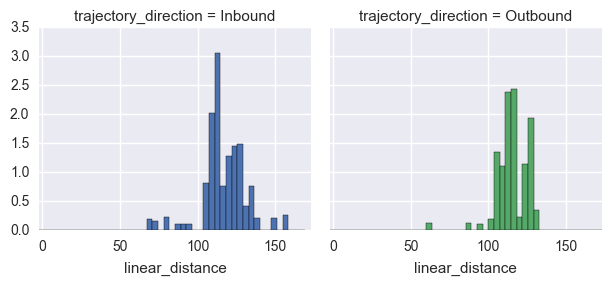

In [143]:
plot_hist_by_factors(train_spikes_data[bad_ind], train_position_info,
                     'trajectory_direction', 'linear_distance', num_bins=49)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


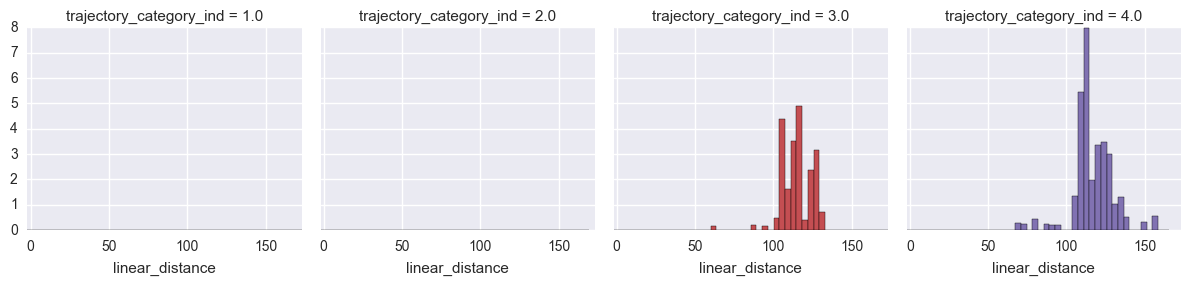

In [145]:
plot_hist_by_factors(train_spikes_data[bad_ind], train_position_info,
                     'trajectory_category_ind', 'linear_distance', num_bins=49)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_spike   No. Observations:               896799
Model:                            GLM   Df Residuals:                   896788
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -975.45
Date:                Fri, 18 Nov 2016   Deviance:                       1718.9
Time:                        15:32:57   Pearson chi2:                 6.46e+05
No. Iterations:                    30                                         
                                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -59.7761     30.329     -1.971 

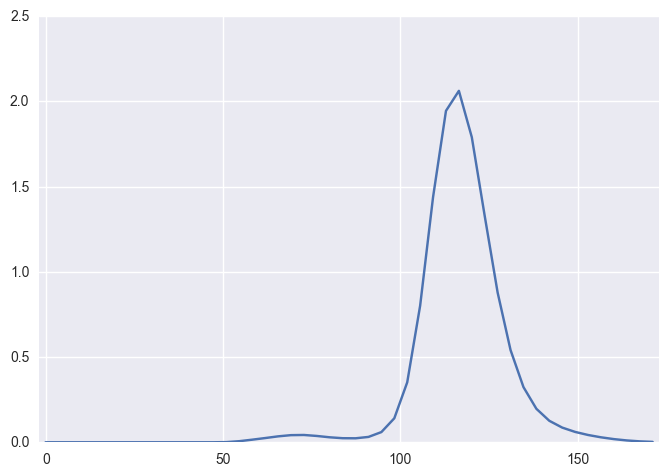

In [210]:
formula = '1 + bs(linear_distance, df=10, degree=3)'
design_matrix = patsy.dmatrix(
    formula, train_position_info, return_type='dataframe')
fitted_model = sm.GLM(train_spikes_data[bad_ind], design_matrix, family=sm.families.Poisson()).fit(maxiter=30, drop='missing')

def _get_grid_centers(grid):
    return grid[:-1] + np.diff(grid) / 2

linear_distance_grid_num_bins = 49
linear_distance_grid = np.linspace(np.floor(position_info.linear_distance.min()),
                                   np.ceil(position_info.linear_distance.max()),
                                   linear_distance_grid_num_bins)
linear_distance_grid_centers = _get_grid_centers(linear_distance_grid)
predictors = {'linear_distance': linear_distance_grid_centers}
predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info], predictors)[0]
plt.plot(linear_distance_grid_centers, fitted_model.predict(predict_design_matrix) * sampling_frequency)
plt.xlim((linear_distance_grid.min(), linear_distance_grid.max()));

print(fitted_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_spike   No. Observations:               896799
Model:                            GLM   Df Residuals:                   896797
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1153.6
Date:                Fri, 18 Nov 2016   Deviance:                       2075.1
Time:                        15:33:40   Pearson chi2:                 8.97e+05
No. Iterations:                    13                                         
                                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercept                           -8.8168      0.130    -67.723      0.000        -9.

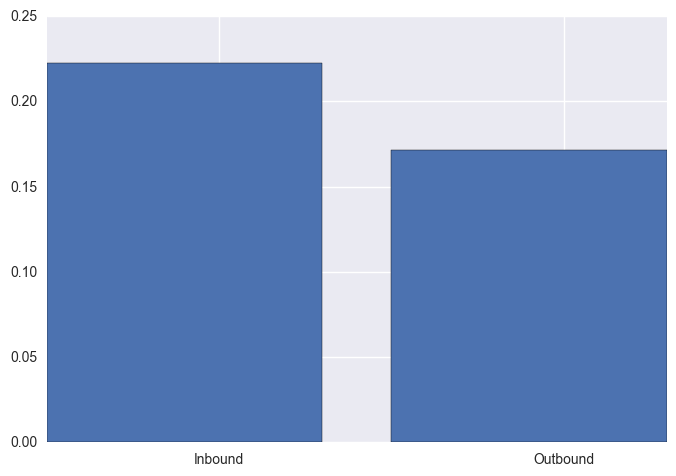

In [211]:
formula = '1 + trajectory_direction'
design_matrix = patsy.dmatrix(
    formula, train_position_info, return_type='dataframe')
fitted_model = sm.GLM(train_spikes_data[bad_ind], design_matrix, family=sm.families.Poisson()).fit(maxiter=30, drop='missing')

predictors = {'trajectory_direction': ['Inbound', 'Outbound']}
predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info], predictors)[0]
inbound = plt.bar(0,  fitted_model.predict(predict_design_matrix)[0] * sampling_frequency)
outbound = plt.bar(1,  fitted_model.predict(predict_design_matrix)[1] * sampling_frequency)
plt.xticks([0.5, 1.5], ['Inbound', 'Outbound']);
print(fitted_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_spike   No. Observations:               896799
Model:                            GLM   Df Residuals:                   896787
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -974.87
Date:                Fri, 18 Nov 2016   Deviance:                       1717.7
Time:                        15:35:01   Pearson chi2:                 6.23e+05
No. Iterations:                    30                                         
                                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -59.6181     32.660     -1.825 

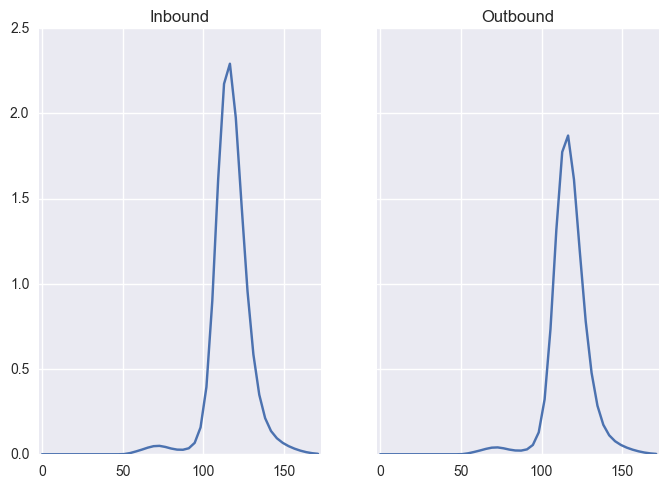

In [212]:
formula = '1 + bs(linear_distance, df=10, degree=3) + trajectory_direction'
design_matrix = patsy.dmatrix(
    formula, train_position_info, return_type='dataframe')
fitted_model = sm.GLM(train_spikes_data[bad_ind], design_matrix, family=sm.families.Poisson()).fit(maxiter=30, drop='missing')

def _get_grid_centers(grid):
    return grid[:-1] + np.diff(grid) / 2

linear_distance_grid_num_bins = 49
linear_distance_grid = np.linspace(np.floor(position_info.linear_distance.min()),
                                   np.ceil(position_info.linear_distance.max()),
                                   linear_distance_grid_num_bins)
linear_distance_grid_centers = _get_grid_centers(linear_distance_grid)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

predictors = {'linear_distance': linear_distance_grid_centers, 
              'trajectory_direction': ['Inbound'] *
                  len(linear_distance_grid_centers)}
predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info], predictors)[0]
ax[0].plot(linear_distance_grid_centers, fitted_model.predict(predict_design_matrix) * sampling_frequency)
ax[0].set_xlim((linear_distance_grid.min(), linear_distance_grid.max()));
ax[0].set_title('Inbound')

predictors = {'linear_distance': linear_distance_grid_centers, 
              'trajectory_direction': ['Outbound'] *
                  len(linear_distance_grid_centers)}
predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info], predictors)[0]
ax[1].plot(linear_distance_grid_centers, fitted_model.predict(predict_design_matrix) * sampling_frequency)
ax[1].set_xlim((linear_distance_grid.min(), linear_distance_grid.max()));
ax[1].set_title('Outbound')
print(fitted_model.summary())

In [197]:
formula = '1 + bs(linear_distance, df=10, degree=3) * trajectory_direction'
design_matrix = patsy.dmatrix(
    formula, train_position_info, return_type='dataframe')
fitted_model = sm.GLM(train_spikes_data[bad_ind], design_matrix, family=sm.families.Poisson()).fit(maxiter=30, drop='missing')


/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/links.py:422: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:347: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog/mu)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:347: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog/mu)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:121: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/genmod/families/family.py:121: RuntimeWarning:

LinAlgError: SVD did not converge

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_spike   No. Observations:               896799
Model:                            GLM   Df Residuals:                   896777
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -907.89
Date:                Fri, 18 Nov 2016   Deviance:                       1583.8
Time:                        15:49:38   Pearson chi2:                 3.94e+05
No. Iterations:                    30                                         
                                                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                

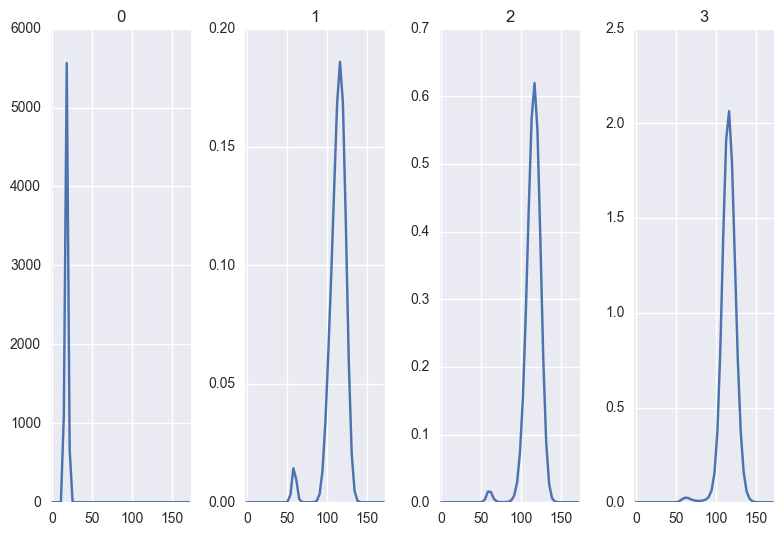

In [215]:
formula = '1 + bs(linear_distance, df=10, degree=3) * trajectory_category_ind'
design_matrix = patsy.dmatrix(
    formula, train_position_info, return_type='dataframe')
fitted_model = sm.GLM(train_spikes_data[bad_ind], design_matrix, family=sm.families.Poisson()).fit(maxiter=30, drop='missing')

print(fitted_model.summary())

fig, ax = plt.subplots(1, 4)

for ind in np.arange(4):
    predictors = {'linear_distance': linear_distance_grid_centers, 
                  'trajectory_category_ind': [ind] *
                      len(linear_distance_grid_centers)}
    predict_design_matrix = patsy.build_design_matrices([design_matrix.design_info], predictors)[0]
    ax[ind].plot(linear_distance_grid_centers, fitted_model.predict(predict_design_matrix) * sampling_frequency)
    ax[ind].set_xlim((linear_distance_grid.min(), linear_distance_grid.max()));
    ax[ind].set_title(ind)

plt.tight_layout()

### Check position dataframe

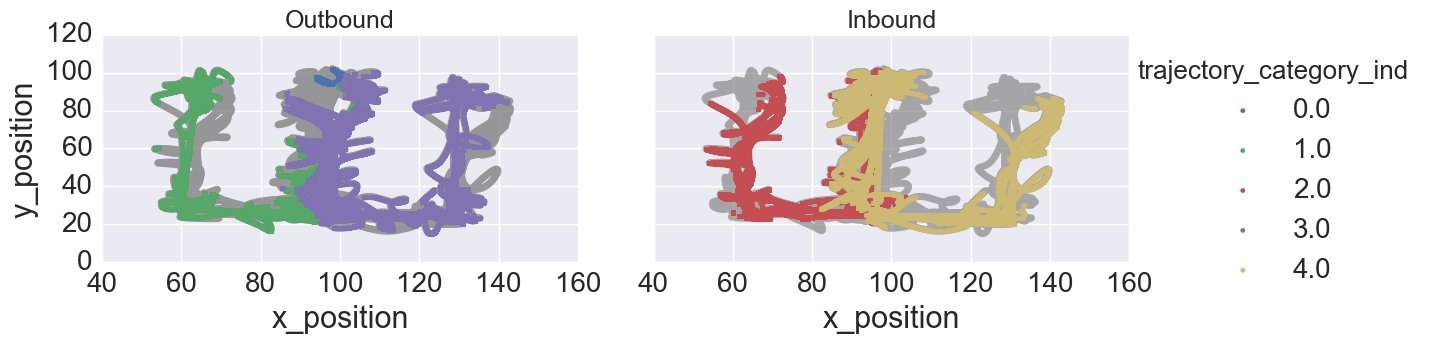

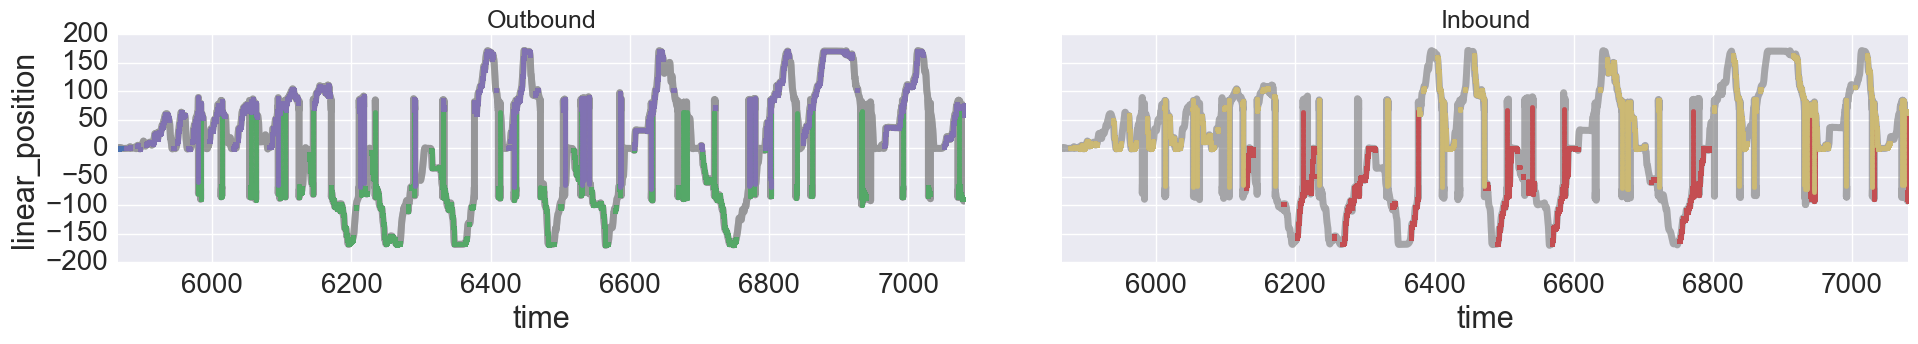

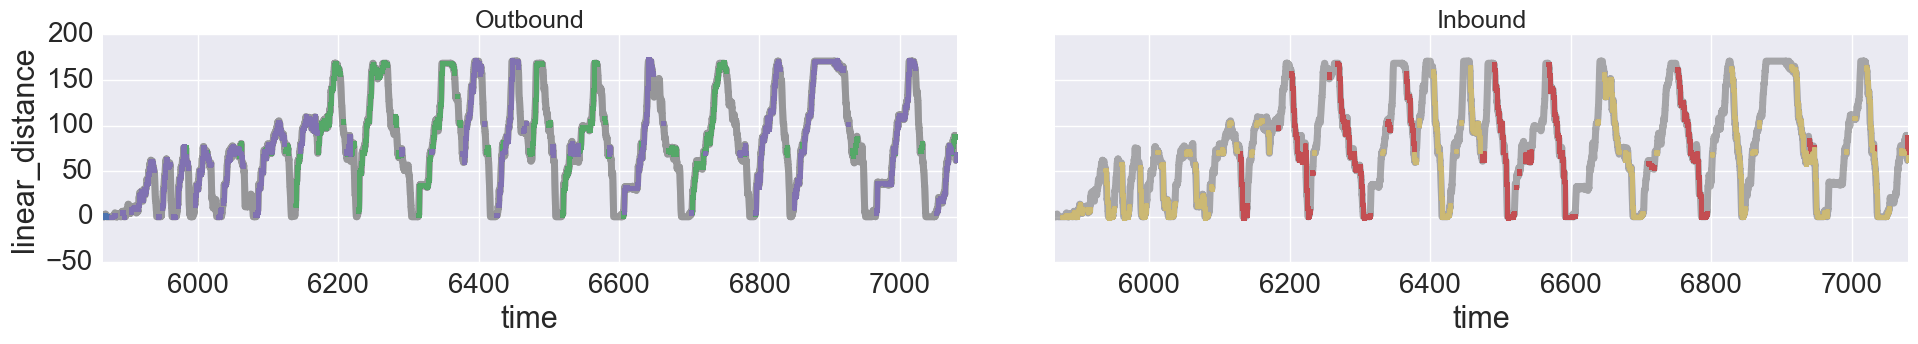

In [226]:
def scatter_wrap(x, y, df, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    ax.plot(df[x], df[y], color='grey', zorder=1, linewidth=5, alpha=0.4)
    ax.scatter(data[x], data[y], **kwargs, zorder=2, s=10)

sns.set(font_scale=2)
grid = sns.FacetGrid(position_info, col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=1.5)
grid.map_dataframe(scatter_wrap, 'x_position', 'y_position', position_info)
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
grid.add_legend()

grid = sns.FacetGrid(position_info.reset_index(), col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=2.5)
grid.map_dataframe(scatter_wrap, 'time', 'linear_position', position_info.reset_index())
grid.set(xlim=(position_info.index.min(), position_info.index.max()))
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)

grid = sns.FacetGrid(position_info.reset_index(), col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=2.5)
grid.map_dataframe(scatter_wrap, 'time', 'linear_distance', position_info.reset_index())
grid.set(xlim=(position_info.index.min(), position_info.index.max()))
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)

In [223]:
def _linear_position(df):
    is_left_arm = (df.trajectory_category_ind == 1) | (
        df.trajectory_category_ind == 2)
    return np.where(is_left_arm, -1 * df.linear_distance, df.linear_distance)


def _trial_number(df):
    return np.cumsum(df.trajectory_category_ind.diff().fillna(0) > 0) + 1


def _trajectory_turn(df):
    trajectory_turn = {0: np.nan, 1: 'Left', 2: 'Right', 3: 'Left', 4: 'Right'}
    return df.trajectory_category_ind.map(trajectory_turn)


def _trajectory_direction(df):
    trajectory_direction = {0: np.nan, 1: 'Outbound',
                            2: 'Inbound', 3: 'Outbound', 4: 'Inbound'}
    return df.trajectory_category_ind.map(trajectory_direction)

time = data_processing.get_trial_time(epoch_index, animals)
position = (pd.concat([data_processing.get_linear_position_structure(epoch_index, animals),
                       data_processing.get_position_dataframe(epoch_index, animals)], axis=1)
            .assign(trajectory_direction=_trajectory_direction)
            .assign(trajectory_turn=_trajectory_turn)
            .assign(trial_number=_trial_number)
            .assign(linear_position=_linear_position)
            )

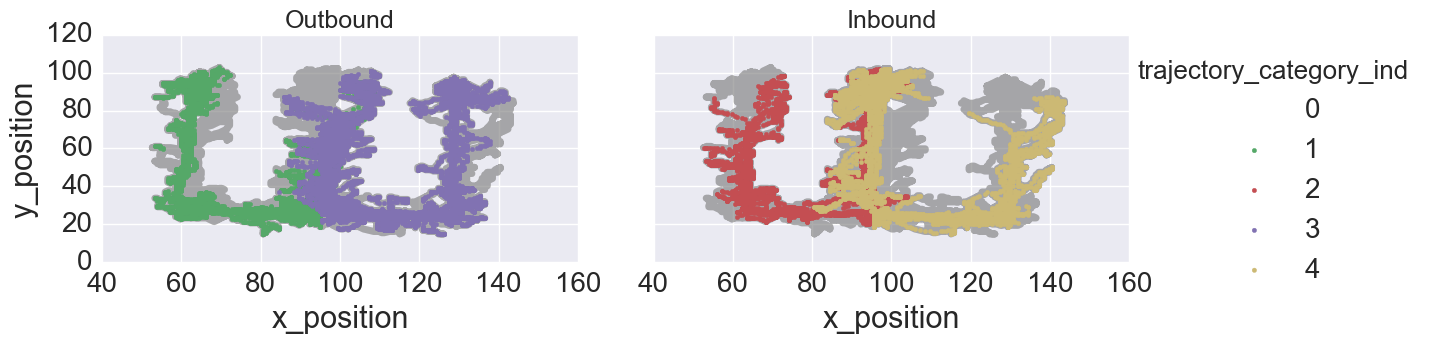

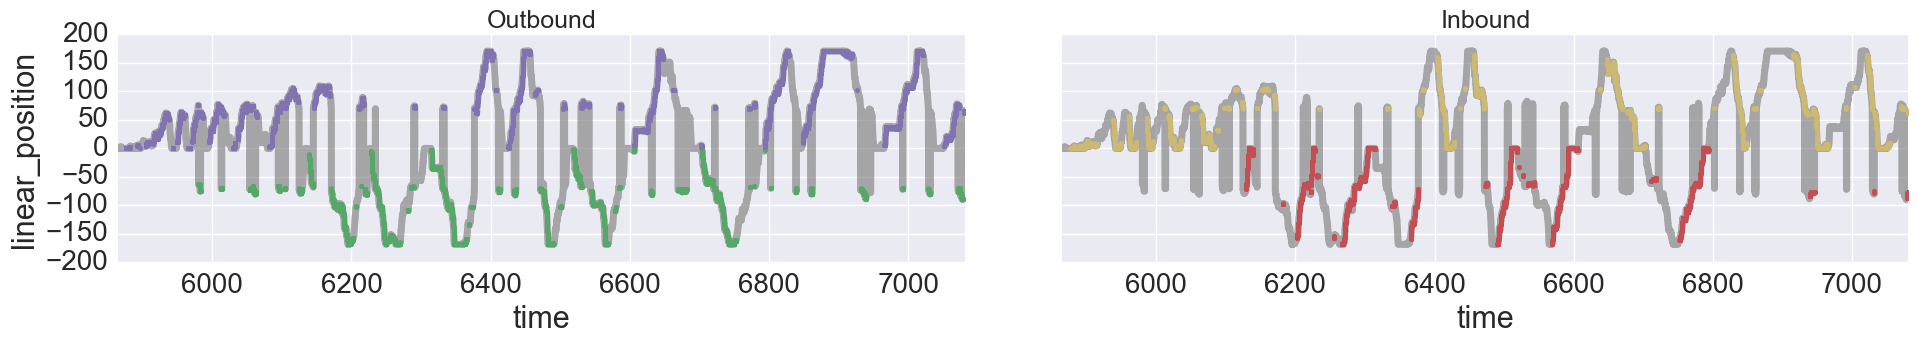

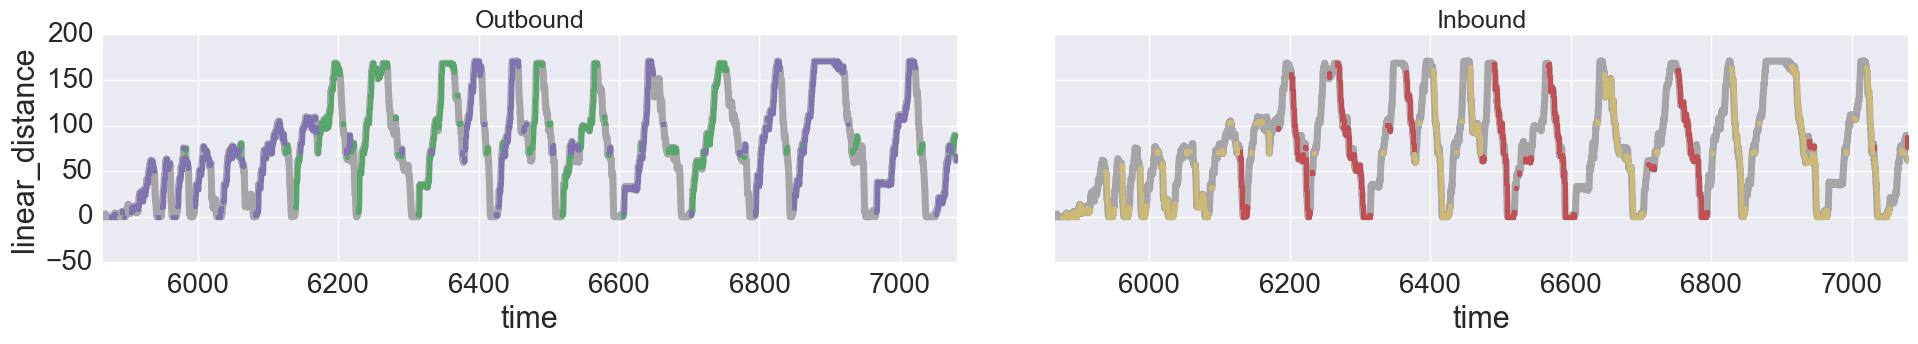

In [225]:
def scatter_wrap(x, y, df, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    ax.plot(df[x], df[y], color='grey', zorder=1, linewidth=5, alpha=0.4)
    ax.scatter(data[x], data[y], **kwargs, zorder=2, s=10)

sns.set(font_scale=2)
grid = sns.FacetGrid(position, col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=1.5)
grid.map_dataframe(scatter_wrap, 'x_position', 'y_position', position)
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
grid.add_legend()

grid = sns.FacetGrid(position.reset_index(), col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=2.5)
grid.map_dataframe(scatter_wrap, 'time', 'linear_position', position.reset_index())
grid.set(xlim=(position.index.min(), position.index.max()))
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)

grid = sns.FacetGrid(position.reset_index(), col='trajectory_direction',
                     hue='trajectory_category_ind', size=4, aspect=2.5)
grid.map_dataframe(scatter_wrap, 'time', 'linear_distance', position.reset_index())
grid.set(xlim=(position.index.min(), position.index.max()))
grid.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)